#### Tutorial 5 - Coalition vs. Opposition Dynamics

This tutorial pulls together the skills and methods we developed in the previous tutorials - analyzing **topic distributions and sentiment** - and applies them to a new focus: **party alignment**. By comparing **coalition and opposition** behaviors, we not only deepen our understanding of a single parliament (like we did in **Tutorial 2, Section 3.4**), but also scale the analysis across multiple countries. This demonstrates the **transferability of our workflow** and allows us to uncover patterns that are **robust across different parliamentary systems**. 

What we will do:
1) Compute normalized **topic shares** (based on word count) for coalition and oppisition and visualize  with a heatmap. We will also calculate the cosine distance to compare the ranking of topics between the two groups to see how much they agree.
2) Look at **differences in word counts** to see which group talks more about certain topics.
3) Calculate **average sentiment** separately for coalitions and oppositions to se if they express similar tones.

With this approach, we aim to answer **possible research questions**, such as:
- *Do Coalitions and Oppositions across parliaments agree on what's important?*
- *Do Coalitions and Oppositions across parliaments express similar tones on the same topic?*



**1. Setup & Data Loading**

This setup (installing/importing) libraries and data loading & filtering steps are the **same as in Tutorial 1**. For detailed explanations, see **Tutorial 1, Sections 1-2**.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import numpy as np
import csv
import scipy.cluster.hierarchy as sch

In [2]:
# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

In [3]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4597575, 21)


In [4]:
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()

**3. Proportions of words by party status and CAP category**

The code below visualizes **how coalition and opposition give attention differently on various policy topics** (based on **word count** of their speeches).

C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\2992354706.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category', 'party_status'])['word_count']
C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\2992354706.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wordcount_status['prop'] = wordcount_status.groupby(['country', 'CAP_category'])['word_count'].transform(lambda x: x / x.sum())


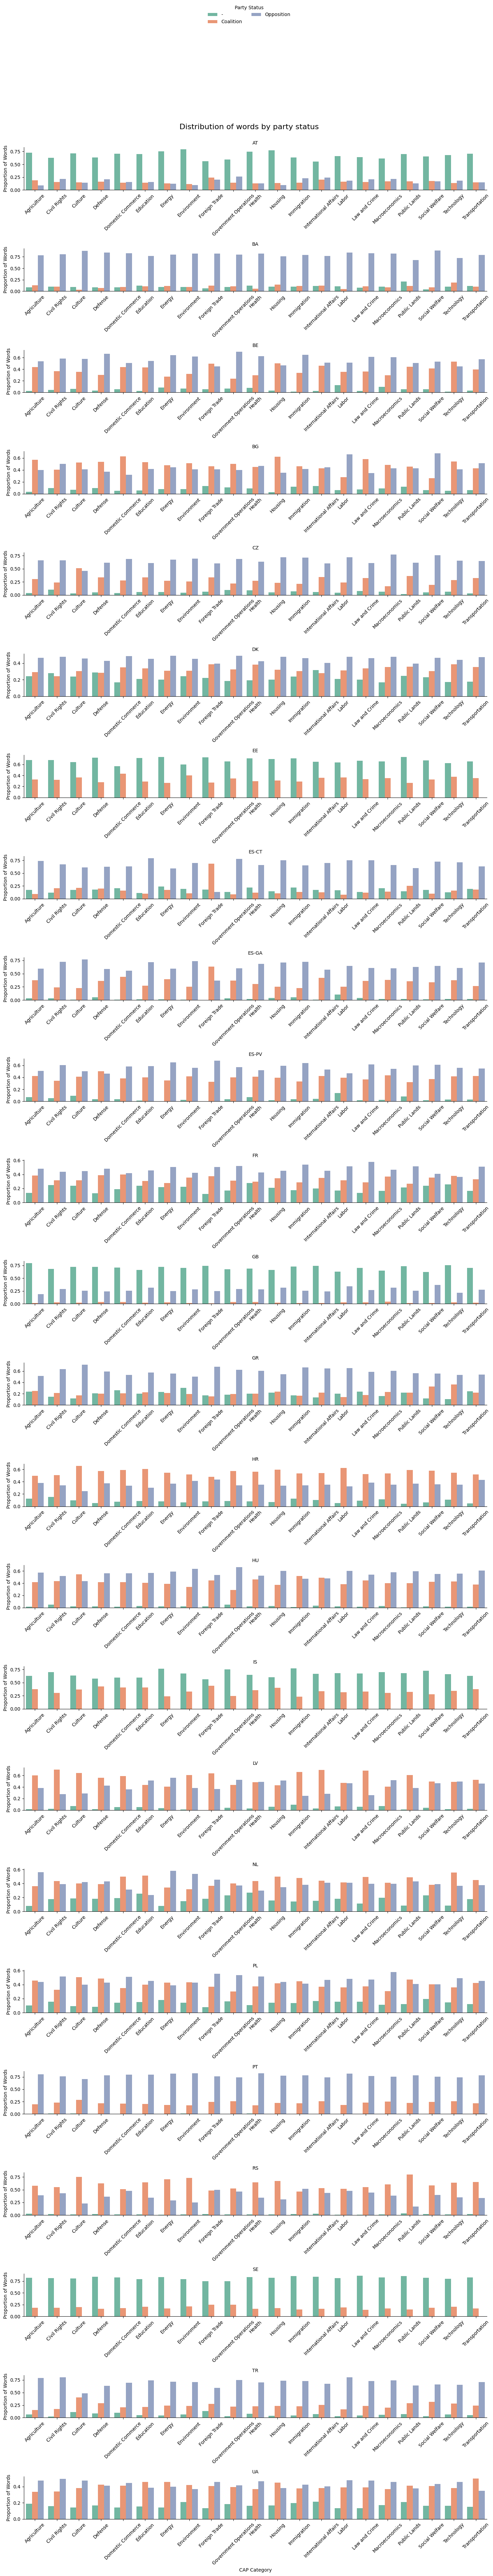

In [11]:
# ---- 1. Aggregate total word count by country, CAP category, and party_status ----
wordcount_status = (
    filtered_all
    .groupby(['country', 'CAP_category', 'party_status'])['word_count']
    .sum()
    .reset_index()
)

# ---- 2. Normalize by total word count in that CAP category per country ----
wordcount_status['prop'] = wordcount_status.groupby(['country', 'CAP_category'])['word_count'].transform(lambda x: x / x.sum())

# ---- 3. Filter out rows that don't have annotated party_status ----
#wordcount_status = wordcount_status[wordcount_status['party_status'].isin(['Coalition', 'Opposition', '-'])]

# ---- 4. Plot: one row per country, CAP categories on x-axis, proportions on y-axis ----
g = sns.FacetGrid(wordcount_status, row='country', sharey=False, height=3, aspect=4)
g.map_dataframe(sns.barplot, x='CAP_category', y='prop', hue='party_status', palette='Set2')
g.set_axis_labels("CAP Category", "Proportion of Words")
g.set_titles("{row_name}")
g.add_legend(title="Party Status", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
g.fig.suptitle("Distribution of words by party status", fontsize=16, y=1)
g.fig.subplots_adjust(top=0.95)

# ---- 5. Rotate x-axis labels for readability AND show them on all subplots ----
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.set_xlabel('CAP Category')  # Add x-axis label to every subplot
    # Ensure x-axis ticks and labels are visible
    ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)

plt.tight_layout()
plt.show()

**Spearman correlation of proportions of words by party status and CAP category** 

*Do Coalitions and Oppositions across parliaments agree on what's important?*

- Value = 1 --> highest similarity 
- Value = 0 --> no similarity at all

C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\196630972.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["country", "CAP_category"])["sent_logit"]


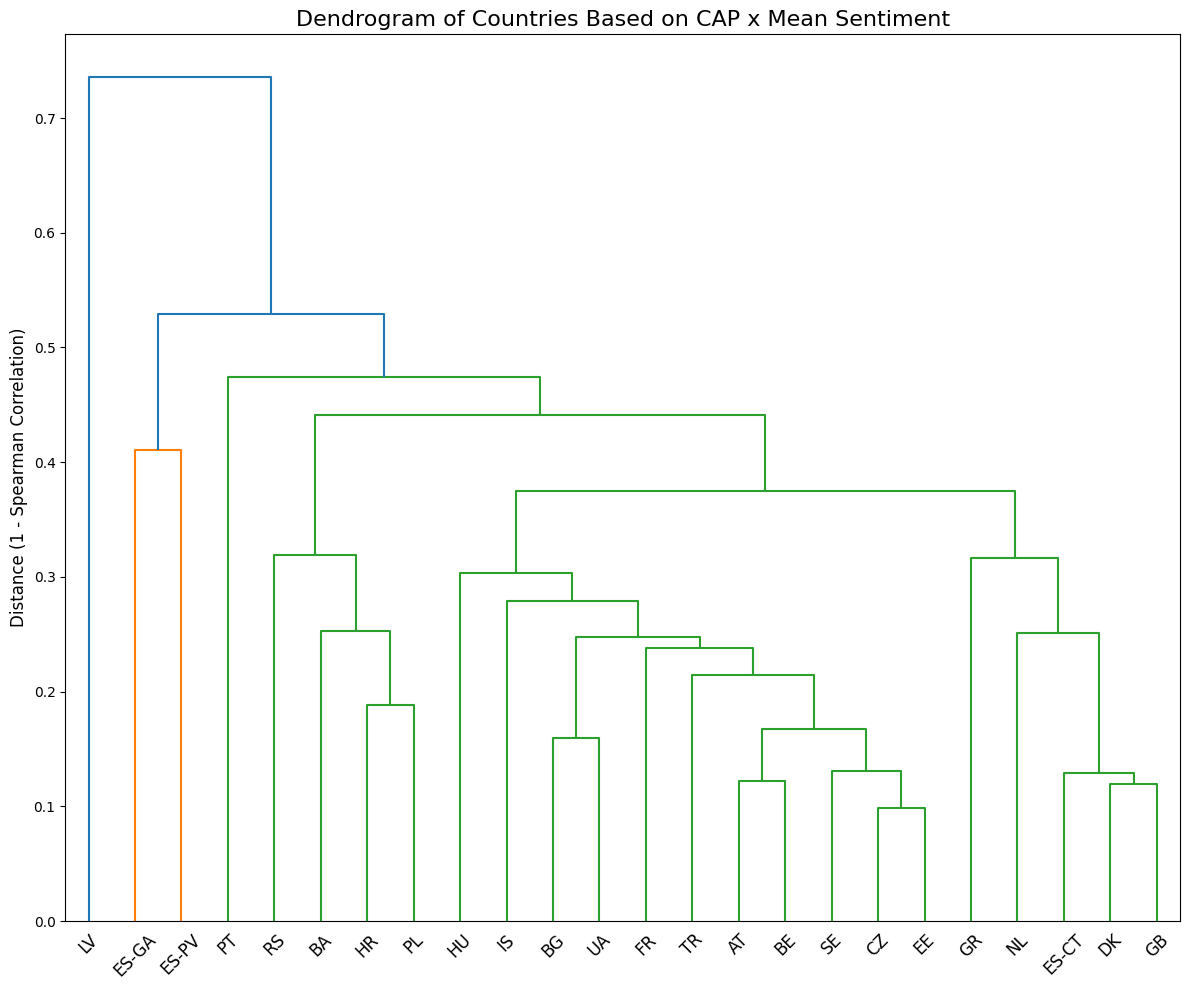

In [18]:
# ---- 1. Prepare country x CAP category matrix (mean sentiment) ----
country_cap_sent = (
    filtered_all
    .groupby(["country", "CAP_category"])["sent_logit"]
    .mean()
    .unstack(fill_value=0)  # rows = country, columns = CAP_category
)

# ---- 2. Compute Spearman correlation between countries ----
# Transpose to correlate rows (countries)
country_correlation = country_cap_sent.T.corr(method='spearman')

# ---- 3. Convert correlation to distance ----
distance_matrix = 1 - country_correlation

# ---- 4. Convert to condensed form for linkage ----
condensed_dist = squareform(distance_matrix)

# ---- 5. Compute linkage matrix ----
linkage_matrix = sch.linkage(condensed_dist, method='average')

# ---- 6. Plot dendrogram ----
plt.figure(figsize=(12, 10))
dendro = sch.dendrogram(
    linkage_matrix,
    labels=country_correlation.index,
    leaf_rotation=45,
    leaf_font_size=12,
    color_threshold=0.5
)
plt.title('Dendrogram of Countries Based on CAP x Mean Sentiment', fontsize=16)
plt.ylabel('Distance (1 - Spearman Correlation)', fontsize=12)
plt.tight_layout()
plt.show()

**4. Relative differences between party statuses**

This code calcualtes the **relative** ((Coalition - Opposition)/Total) **differences** between party statuses and visualizes that using heatmaps.

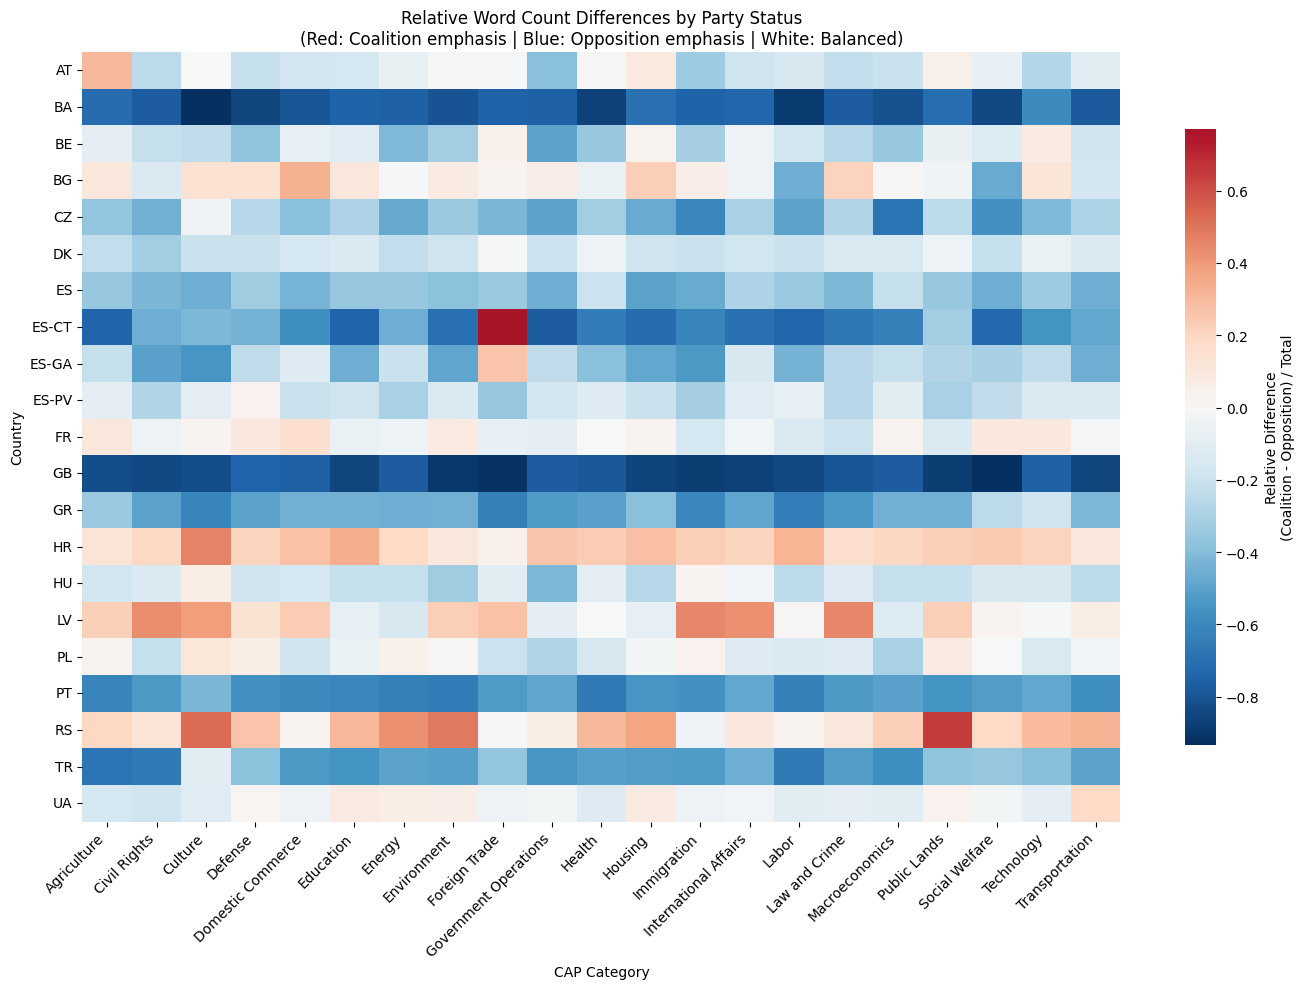

Relative Differences Table (Coalition - Opposition / Total):
CAP_category  Agriculture  Civil Rights  Culture  Defense  Domestic Commerce  \
country                                                                        
AT                  0.303        -0.250   -0.007   -0.210             -0.170   
BA                 -0.718        -0.775   -0.928   -0.852             -0.798   
BE                 -0.099        -0.227   -0.239   -0.375             -0.079   
BG                  0.108        -0.134    0.140    0.142              0.326   
CZ                 -0.362        -0.446   -0.037   -0.259             -0.391   
DK                 -0.229        -0.325   -0.202   -0.206             -0.165   
ES                 -0.349        -0.427   -0.449   -0.333             -0.431   
ES-CT              -0.744        -0.449   -0.418   -0.434             -0.571   
ES-GA              -0.225        -0.501   -0.547   -0.238             -0.120   
ES-PV              -0.096        -0.277   -0.098    0.041  

In [ ]:
# ---- 1. Calculate relative differences ----
pivot_df = wordcount_status.pivot_table(
    index=['country', 'CAP_category'],
    columns='party_status',
    values='word_count',
    fill_value=0
).reset_index()

# Calculate relative difference (Coalition - Opposition) / (Coalition + Opposition)
if 'Coalition' in pivot_df.columns and 'Opposition' in pivot_df.columns:
    total_words = pivot_df['Coalition'] + pivot_df['Opposition']
    pivot_df['rel_diff'] = (pivot_df['Coalition'] - pivot_df['Opposition']) / (total_words + 1e-10)  # +1e-10 to avoid division by zero

# ---- 2. Clean Relative Difference Heatmap ----
plt.figure(figsize=(14, 10))
rel_pivot = pivot_df.pivot(index='country', columns='CAP_category', values='rel_diff')

# Create clean heatmap without annotations
sns.heatmap(rel_pivot, 
            cmap='RdBu_r', 
            center=0,
            annot=False,  # No values in boxes
            cbar_kws={'label': 'Relative Difference\n(Coalition - Opposition) / Total', 
                     'shrink': 0.8})

plt.title('Relative Word Count Differences by Party Status\n(Red: Coalition emphasis | Blue: Opposition emphasis | White: Balanced)')
plt.xlabel('CAP Category')
plt.ylabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 3. Optional: Print the actual values as a table ----
print("Relative Differences Table (Coalition - Opposition / Total):")
print(rel_pivot.round(3))  # Rounded to 3 decimal places

**5. Mean sentiment by party status and CAP category**


**What this code does:**
- Calculates average sentiment (positive/negative tone) for coalition/opposition parties across countries and per CAP category
- Creates heatmaps 
- Provides summary statistics and detailed data tables

C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\3816747315.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['sent_logit']
C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\3816747315.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['sent_logit']
C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\3816747315.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

MEAN SENTIMENT SUMMARY ACROSS ALL COUNTRIES

Overall Mean Sentiment (All Parties):
Mean: 2.070
Std: 0.296
Min: 1.095
Max: 3.188

Coalition Mean Sentiment:
Mean: 2.444
Std: 0.319
Min: 1.318
Max: 3.438

Opposition Mean Sentiment:
Mean: nan
Std: nan
Min: nan
Max: nan

DETAILED MEAN SENTIMENT BY COUNTRY
   country  overall_mean  coalition_mean  opposition_mean  difference
0       AT         2.227           2.661            1.710       0.951
1       BA         2.090           2.111            2.087       0.024
2       BE         1.949           2.254            1.783       0.470
3       BG         2.177           2.496            1.914       0.582
4       CZ         2.083           2.461            1.862       0.599
5       DK         2.050           2.427            1.837       0.590
6       EE         1.795           2.033              NaN         NaN
7    ES-CT         1.921           2.581            1.652       0.929
8    ES-GA         1.687           2.225            1.396       0.829

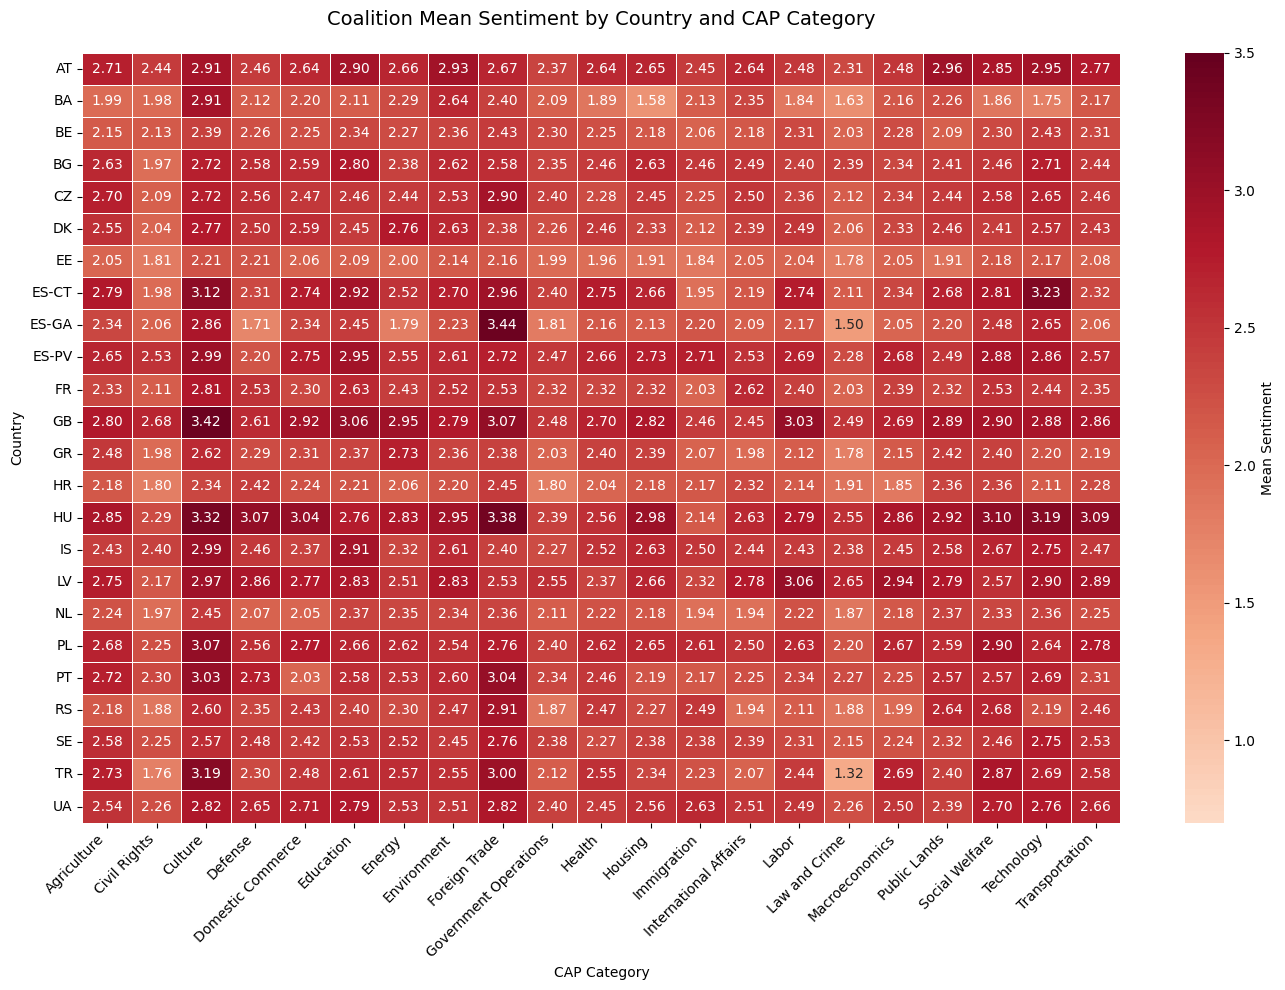

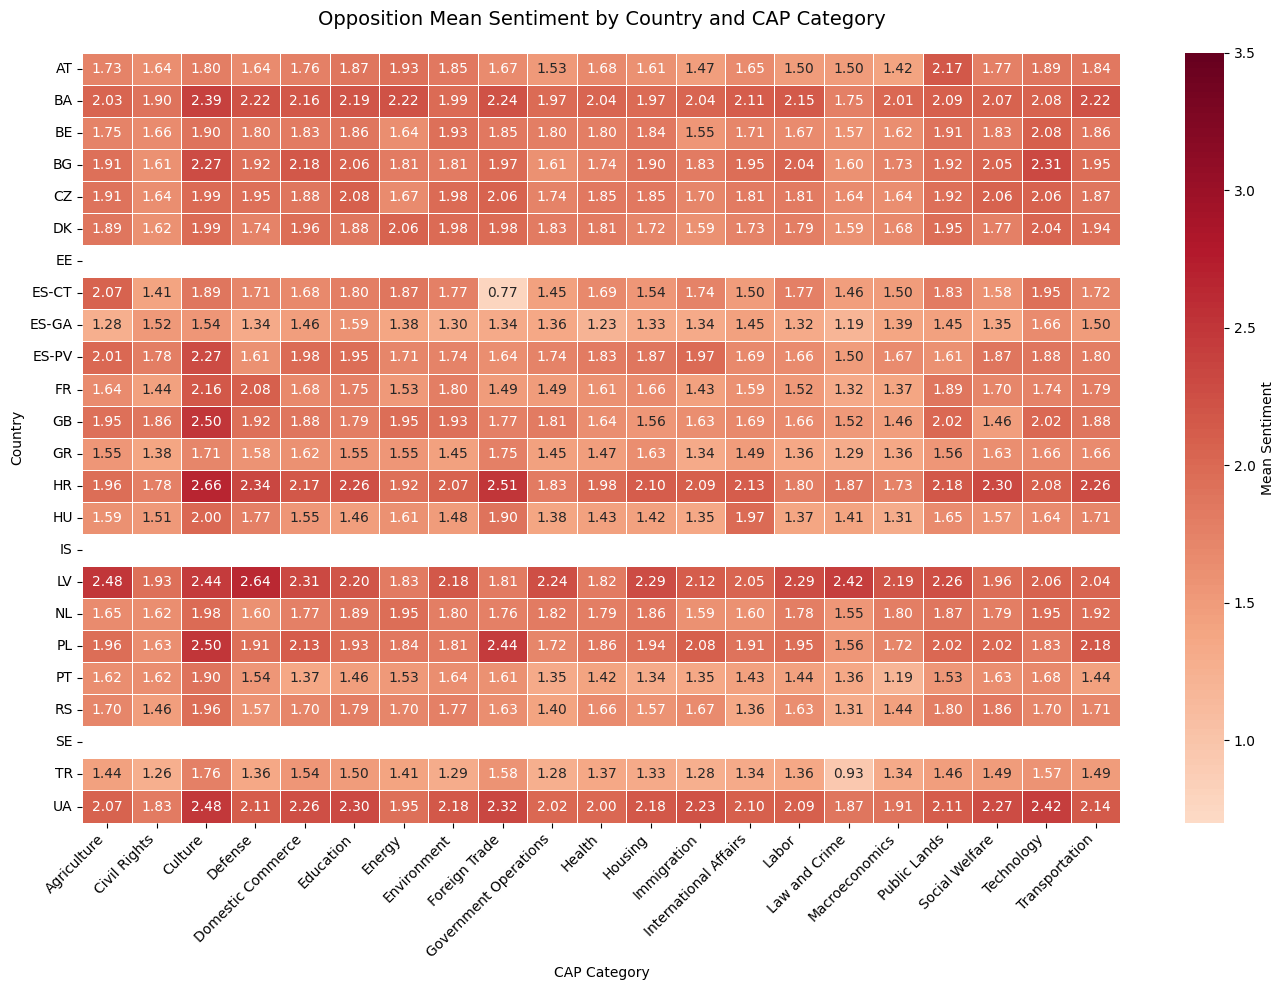

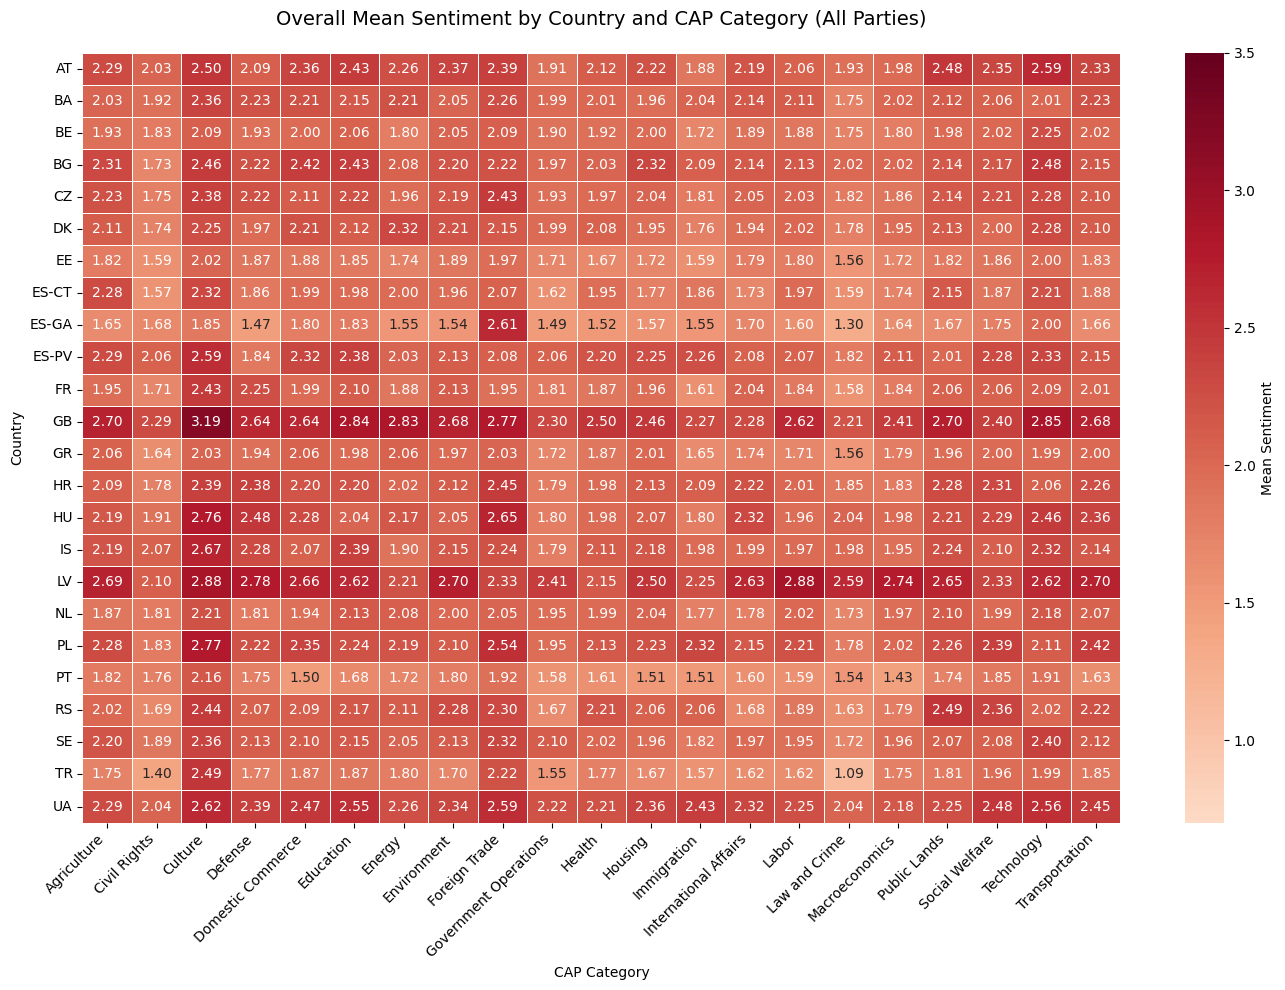


COALITION SENTIMENT DATA TABLE
CAP_category  Agriculture  Civil Rights  Culture  Defense  Domestic Commerce  \
country                                                                        
AT                  2.710         2.440    2.909    2.460              2.635   
BA                  1.993         1.975    2.911    2.116              2.200   
BE                  2.153         2.134    2.395    2.257              2.248   
BG                  2.626         1.967    2.725    2.579              2.590   
CZ                  2.702         2.091    2.716    2.561              2.471   
DK                  2.547         2.037    2.774    2.502              2.586   
EE                  2.052         1.808    2.213    2.207              2.059   
ES-CT               2.789         1.977    3.122    2.311              2.740   
ES-GA               2.336         2.063    2.860    1.710              2.342   
ES-PV               2.648         2.530    2.988    2.200              2.751   
FR      

In [20]:
# ---- 1. Compute mean sentiment by country and CAP category ----
# Overall (both parties combined)
overall_sentiment = (
    filtered_all
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack(fill_value=0)
)

# Coalition
coalition_sentiment = (
    filtered_all[filtered_all['party_status'] == 'Coalition']
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack(fill_value=0)
)

# Opposition
opposition_sentiment = (
    filtered_all[filtered_all['party_status'] == 'Opposition']
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack(fill_value=0)
)

# ---- 1.1 Reindex coalition and opposition to include all countries ----
all_countries = overall_sentiment.index
coalition_sentiment = coalition_sentiment.reindex(all_countries)
opposition_sentiment = opposition_sentiment.reindex(all_countries)

# ---- 2. Print summary statistics ----
print("MEAN SENTIMENT SUMMARY ACROSS ALL COUNTRIES")
print("=" * 50)
print("\nOverall Mean Sentiment (All Parties):")
print(f"Mean: {overall_sentiment.values.mean():.3f}")
print(f"Std: {overall_sentiment.values.std():.3f}")
print(f"Min: {overall_sentiment.values.min():.3f}")
print(f"Max: {overall_sentiment.values.max():.3f}")

print("\nCoalition Mean Sentiment:")
print(f"Mean: {coalition_sentiment.values.mean():.3f}")
print(f"Std: {coalition_sentiment.values.std():.3f}")
print(f"Min: {coalition_sentiment.values.min():.3f}")
print(f"Max: {coalition_sentiment.values.max():.3f}")

print("\nOpposition Mean Sentiment:")
print(f"Mean: {opposition_sentiment.values.mean():.3f}")
print(f"Std: {opposition_sentiment.values.std():.3f}")
print(f"Min: {opposition_sentiment.values.min():.3f}")
print(f"Max: {opposition_sentiment.values.max():.3f}")

# ---- 3. Print detailed mean sentiment by country ----
print("\n" + "=" * 50)
print("DETAILED MEAN SENTIMENT BY COUNTRY")
print("=" * 50)

country_stats = []
for country in overall_sentiment.index:
    country_stats.append({
        'country': country,
        'overall_mean': overall_sentiment.loc[country].mean(),
        'coalition_mean': coalition_sentiment.loc[country].mean(),
        'opposition_mean': opposition_sentiment.loc[country].mean(),
        'difference': (coalition_sentiment.loc[country].mean() if not coalition_sentiment.loc[country].isna().all() else float('nan')) - 
                      (opposition_sentiment.loc[country].mean() if not opposition_sentiment.loc[country].isna().all() else float('nan'))
    })

country_stats_df = pd.DataFrame(country_stats)
print(country_stats_df.round(3))

# ---- 4. Create heatmap for Coalition sentiment ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    coalition_sentiment,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=0.7,
    vmax=3.5,
    center=0,
    cbar_kws={'label': 'Mean Sentiment'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Coalition Mean Sentiment by Country and CAP Category", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 5. Create heatmap for Opposition sentiment ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    opposition_sentiment,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=0.7,
    vmax=3.5,
    center=0,
    cbar_kws={'label': 'Mean Sentiment'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Opposition Mean Sentiment by Country and CAP Category", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 6. Optional: Create heatmap for overall sentiment ----
plt.figure(figsize=(14, 10))
sns.heatmap(
    overall_sentiment,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=0.7,
    vmax=3.5,
    center=0,
    cbar_kws={'label': 'Mean Sentiment'},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Overall Mean Sentiment by Country and CAP Category (All Parties)", fontsize=14, pad=20)
plt.xlabel("CAP Category")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- 7. Print the actual data tables ----
print("\n" + "=" * 50)
print("COALITION SENTIMENT DATA TABLE")
print("=" * 50)
print(coalition_sentiment.round(3))

print("\n" + "=" * 50)
print("OPPOSITION SENTIMENT DATA TABLE")
print("=" * 50)
print(opposition_sentiment.round(3))

print("\n" + "=" * 50)
print("OVERALL SENTIMENT DATA TABLE")
print("=" * 50)
print(overall_sentiment.round(3))


**6. Spearman correlation of sentiment patterns by party status and CAP category** 

*Do Coalitions and Oppositions across parliaments express similar tones on the same topic*

- Value = 1 --> highest similarity 
- Value = 0 --> no similarity at all


C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\3147079192.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['sent_logit']
C:\Users\isabe\AppData\Local\Temp\ipykernel_6452\3147079192.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['country', 'CAP_category'])['sent_logit']


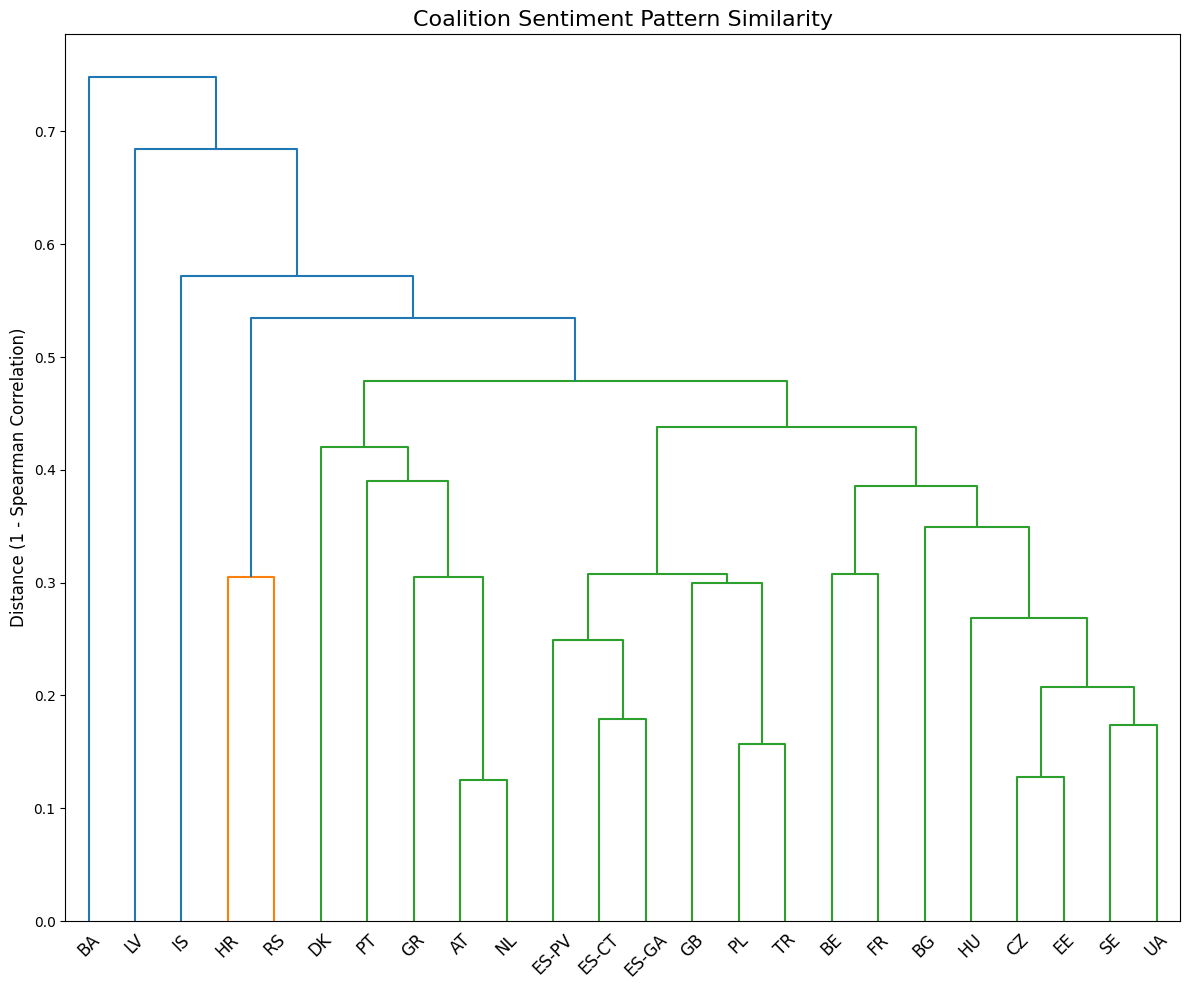

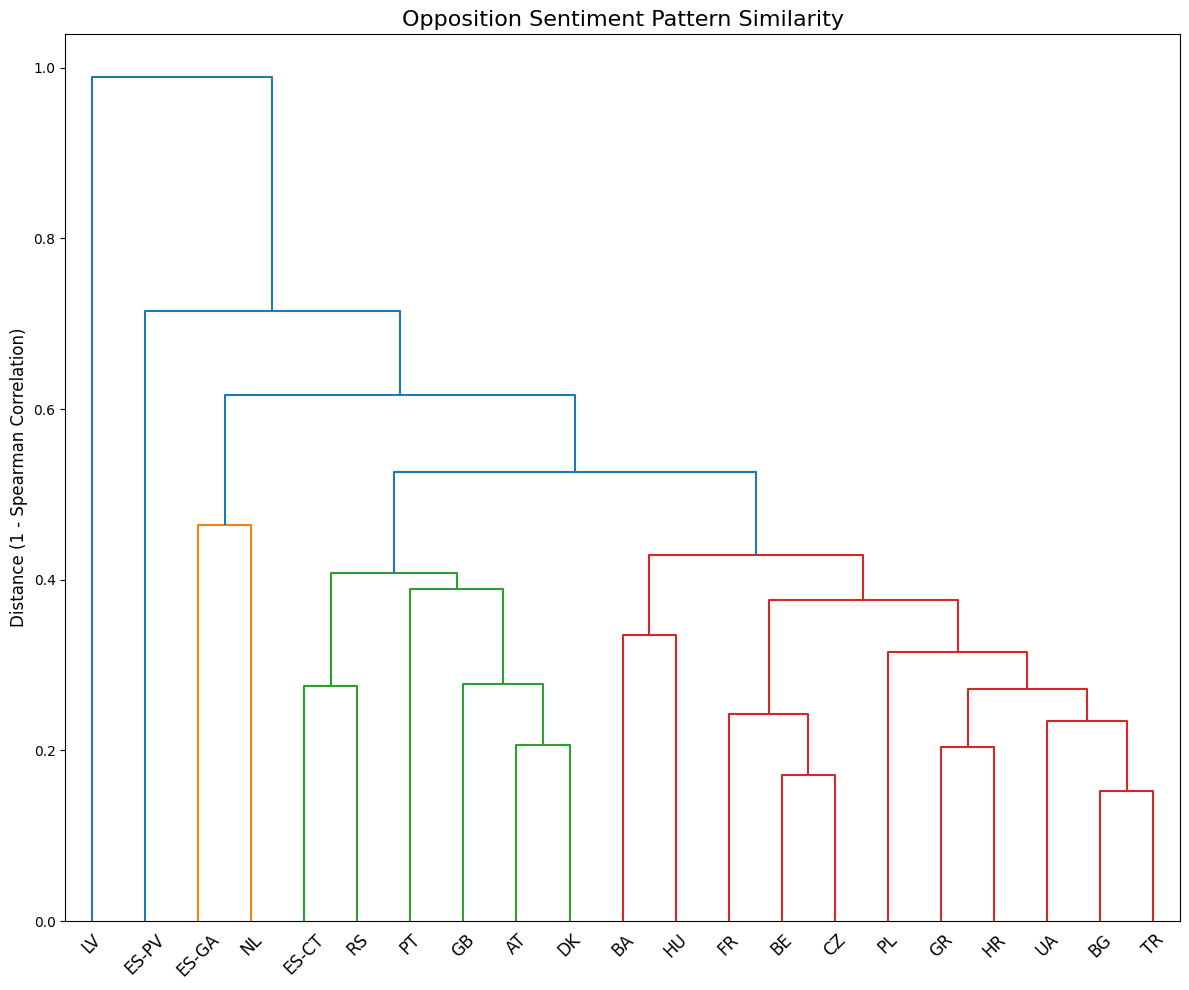

SPEARMAN CORRELATION SUMMARY

Coalition Sentiment Correlation Statistics:
Mean correlation: 0.528
Strongest positive: 1.000
Strongest negative: -0.031

Opposition Sentiment Correlation Statistics:
Mean correlation: 0.481
Strongest positive: 1.000
Strongest negative: -0.181

Cross-Party Sentiment Correlation Statistics:
Mean correlation: 0.455
Strongest positive: 0.905
Strongest negative: -0.222

MOST SIMILAR COUNTRY PAIRS
Top 5 most similar Coalition patterns:
    country1 country2  correlation
16        AT       NL        0.875
87        CZ       EE        0.873
102       CZ       SE        0.865
264       PL       TR        0.843
274       SE       UA        0.826

Top 5 most dissimilar Coalition patterns:
    country1 country2  correlation
30        BA    ES-PV       -0.031
251       LV       RS       -0.031
36        BA       IS       -0.029
213       GR       LV        0.021
28        BA    ES-CT        0.043


In [21]:
# ---- 1. Compute mean sentiment by country and CAP category for both parties ----
coalition_sentiment = (
    filtered_all[filtered_all['party_status'] == 'Coalition']
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack(fill_value=0)
)

opposition_sentiment = (
    filtered_all[filtered_all['party_status'] == 'Opposition']
    .groupby(['country', 'CAP_category'])['sent_logit']
    .mean()
    .unstack(fill_value=0)
)

# ---- 2. Compute Spearman correlation matrices ----
# Coalition sentiment correlation between countries
coalition_corr = coalition_sentiment.T.corr(method='spearman')

# Opposition sentiment correlation between countries  
opposition_corr = opposition_sentiment.T.corr(method='spearman')

# Cross-party correlation: How similar are Coalition patterns to Opposition patterns?
cross_party_corr = pd.DataFrame(index=coalition_sentiment.index, columns=opposition_sentiment.index)
for country1 in coalition_sentiment.index:
    for country2 in opposition_sentiment.index:
        cross_party_corr.loc[country1, country2] = spearmanr(
            coalition_sentiment.loc[country1], 
            opposition_sentiment.loc[country2]
        )[0]

# ---- 3. Create correlation dendrograms ----
# ---- 3.1. Coalition Dendrogram ----
coalition_dist = 1 - coalition_corr
coalition_linkage = sch.linkage(squareform(coalition_dist), method='average')

plt.figure(figsize=(12, 10))
sch.dendrogram(
    coalition_linkage,
    labels=coalition_corr.index,
    leaf_rotation=45,
    leaf_font_size=12,
    color_threshold=0.5
)
plt.title("Coalition Sentiment Pattern Similarity", fontsize=16)
plt.ylabel("Distance (1 - Spearman Correlation)", fontsize=12)
plt.tight_layout()
plt.show()

# ---- 3.2. Opposition Dendrogram ----
opposition_dist = 1 - opposition_corr
opposition_linkage = sch.linkage(squareform(opposition_dist), method='average')

plt.figure(figsize=(12, 10))
sch.dendrogram(
    opposition_linkage,
    labels=opposition_corr.index,
    leaf_rotation=45,
    leaf_font_size=12,
    color_threshold=0.5
)
plt.title("Opposition Sentiment Pattern Similarity", fontsize=16)
plt.ylabel("Distance (1 - Spearman Correlation)", fontsize=12)
plt.tight_layout()
plt.show()


# ---- 4. Print correlation summary statistics ----
print("SPEARMAN CORRELATION SUMMARY")
print("=" * 50)
print("\nCoalition Sentiment Correlation Statistics:")
print(f"Mean correlation: {coalition_corr.values.mean():.3f}")
print(f"Strongest positive: {coalition_corr.values.max():.3f}")
print(f"Strongest negative: {coalition_corr.values.min():.3f}")

print("\nOpposition Sentiment Correlation Statistics:")
print(f"Mean correlation: {opposition_corr.values.mean():.3f}") 
print(f"Strongest positive: {opposition_corr.values.max():.3f}")
print(f"Strongest negative: {opposition_corr.values.min():.3f}")

print("\nCross-Party Sentiment Correlation Statistics:")
print(f"Mean correlation: {cross_party_corr.values.mean():.3f}")
print(f"Strongest positive: {cross_party_corr.values.max():.3f}")
print(f"Strongest negative: {cross_party_corr.values.min():.3f}")

# ---- 5. Identify most and least similar country pairs ----
print("\n" + "=" * 50)
print("MOST SIMILAR COUNTRY PAIRS")
print("=" * 50)

# For coalition similarity
coalition_similar = []
for i in range(len(coalition_corr.index)):
    for j in range(i+1, len(coalition_corr.columns)):
        if coalition_corr.index[i] != coalition_corr.columns[j]:
            coalition_similar.append({
                'country1': coalition_corr.index[i],
                'country2': coalition_corr.columns[j], 
                'correlation': coalition_corr.iloc[i, j]
            })

coalition_similar_df = pd.DataFrame(coalition_similar)
print("Top 5 most similar Coalition patterns:")
print(coalition_similar_df.nlargest(5, 'correlation').round(3))

print("\nTop 5 most dissimilar Coalition patterns:")
print(coalition_similar_df.nsmallest(5, 'correlation').round(3))